# NN Walkthrough

In this notebook

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

# for creating animations
import matplotlib.animation
from IPython.display import HTML

In [2]:
# styling additions
from IPython.display import HTML
# style = "<style>div.warn{background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
style = "<style>div.info{padding: 15px; border: 1px solid transparent; border-left: 5px solid #dfb5b4; border-color: transparent; margin-bottom: 10px; border-radius: 4px; background-color: #fcf8e3; border-color: #faebcc;}</style>"
HTML(style)

## Latex definitions
This cell just creates some latex definitions we will need later:
$$
\newcommand{\dc}{\color{red}{\partial C_0}}
\newcommand{\dw}{\color{blue}{\partial w^{(L)}}}
\newcommand{\dz}{\color{green}{\partial z^{(L)}}}
\newcommand{\da}{\color{orange}{\partial a^{(L)}}}
\newcommand{\dcdw}{\frac{\dc}{\dw}}
\newcommand{\dzdw}{\frac{\dz}{\dw}}
\newcommand{\dadz}{\frac{\da}{\dz}}
\newcommand{\dcda}{\frac{\dc}{\da}}
$$

 # Forward Direction

Lets start with the simplest network we can imagine, and first understand how a neural network calculates its output for a particular input. This is known as the "forward" direction (we will see why later). 

## Dataset

Lets generate a simple 1-D toy dataset:

In [3]:
def toy():
    N = 1000
    inputs = np.linspace(-5,5,N).reshape(N,1)
    labels = ((inputs>0).astype(int)*2-1).reshape(N,1)
    return inputs,labels

In [4]:
inputs,labels = toy()
inputs[0],labels[0]

(array([-5.]), array([-1]))

## 1-D Network

Lets give the simplest network we can imagine. One that consists of a few 1-D "layers" of size 1! We have an:
* input node/layer, 
* hidden node/layer:$h_1$, 
* another hidden node/layer $h_2$
* output node/layer. 

Networks are typically drawn with the **weights** on the wires. Our simple network can be given as:
![](figures/simple_network.png)

<div class="info">

**Note:** This is sometimes confusing, as technically its the **activations** of the previous layer that "flow" into the next layer. However, the weights are what we are tying to **learn**, and their relative **strengths** tells us something about the structure of the network.
    
</div>


Each node has an associated:
* weight
* bias
* activation function

In our example, we have $w_1,b_1,w_2,b_2,w_3,b_3$ as our **parameters** and we are using the **sigmoid** as our activation function.

The function of each node, is to apply its own weight and bias to a previous layers activation value, and then pass it through its activation function to produce its own activation. For example, $h_1$ is doing:

$$
a_1 = \sigma(w\cdot x + b)
$$

The *input* to a nodes activation function is useful to think about separately, so we can introduce an additional variable to denote it as:
$$
z_i = w\cdot x + b, \quad\quad a_1 = \sigma(z_i)
$$

So, we can describe the behavior of each of our nodes as:

![](figures/nodes.png)

### Implementation

Now we can actually implement this simple network. Lets start by recalling the sigmoid function:

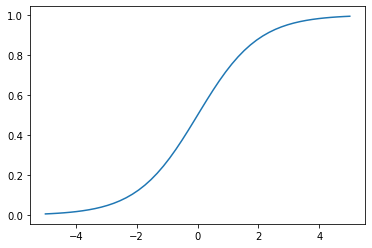

In [5]:
def sigmoid(x):
    val = # EDIT HERE
    return val

plt.plot(np.linspace(-5,5),sigmoid(np.linspace(-5,5)));

Lets define the function of a **node**, being careful to match our notation:

In [6]:
def node(w,b,a):
    # EDIT HERE
    return sigmoid(z)

Now we are ready to define our **actual network**! Lets initialize our random weights and biases:

In [7]:
w1,b1,w2,b2,w3,b3 = # EDIT HERE

Now, lets pick a training example and run it through our network:

In [8]:
input,label = inputs[0],labels[0]

# h1 node - operates on our input
a1 = # EDIT HERE

# h2 node - operates on a1
a2 = # EDIT HERE

# output node - operates on a2 - produces our output
output = # EDIT HERE
y_hat = output

Lets see how we did!

In [9]:
print(f"for input: {input} with label: {label}, this network calculated: {y_hat}")

for input: [-5.] with label: [-1], this network calculated: [0.73672847]


As we know, to actually see how we did, we need to **define a cost**! Lets proceed with the usual average-MSE:

In [10]:
def mse(y_hat,y,average=True):
    if average:
        return # EDIT HERE
    else:
        return # EDIT HERE

In [11]:
print(f"for input: {input} with label: {label}, this network calculated: {output}, giving us a cost of: {mse(output,label)}")

for input: [-5.] with label: [-1], this network calculated: [0.73672847], giving us a cost of: 3.0162257747590586


Ok - so we've demonstrated the entire forward direction, for one sample. Lets define a function for this simple network, so we can run our entire training set through!

In [12]:
def simple_network(inputs):
    outputs = []
    N = inputs.shape[0]
    
    # initialized weights
    w1,b1,w2,b2,w3,b3 = # EDIT HERE

    for i in range(N):
        input = inputs[i,:]
        
        # h1 node
        a1 = # EDIT HERE

        # h2 node
        a2 = # EDIT HERE

        # output node
        output = # EDIT HERE
        
        # append to form output
        outputs.append(output)
    
    return np.asarray(outputs)

We can now calculate our **average loss** over the entire training set:

In [13]:
mse(simple_network(inputs),labels)

1.376286000302102

--- 

## Multidimensional Network


We've looked at a very simple example above which captures the essence of what we are doing. However, our networks are really never actually composed of layers with one element each. Instead, **each** layer has **multiple** nodes. 

Technically, we could continue in the same way as above and individually number our weights and biases but this quickly gets out of hand! As an exercise, try repeating the above analysis and implementation where each hidden layer is now of size 2!

Ironically, to avoid this notational complexity, it seems like we must introduce additional notation, and rewrite our problem in the language of **linear algebra**. 

To introduce this notation, lets imagine a network the following structure:
![](figures/md-1.png)

To make our analysis simpler, lets zoom in on node node, and all of its input weights:

![](figures/md-2.png)

We've highlighted the 0th node in our last hidden layer and all of its inputs from the previous layer in $\color{orange}{\text{orange}}$. We've also numbered each of it input nodes with their layer-specific numbering and shown them in $\color{blue}{\text{blue}}$.

We've also named each weight according to the following format:

$$
w_{\;\color{orange}{\text{current node #}} \;,\; \color{blue}{\text{incoming node #}}}
$$

This may seem a bit counter intuitive at first, as the tendency when reading from left to write is to want to write our weights as:

$$
w_{\;\color{blue}{\text{incoming node #}} \;,\; \color{orange}{\text{current node #}} }
$$

You absolutely can, but that will result in a bunch of transposes in later equations. To get rid of them now, we will number our weights as we did above. As is typically the case, people make seemingly weird/arbitrary decisions at the front to result in simplifications down the line. 

Recall, the function of a node is to apply its weight to the activation of its input/previous layer. In this case, we have three previous nodes/input nodes, so we will also write them in $\color{blue}{\text{blue}}$ to make it clear that they are coming from the previous layer. 

So our orange node is performing:

$$
\color{orange}{w}_{\color{orange}{0},\color{blue}{0}} \cdot \color{blue}{a_0} + 
\color{orange}{w}_{\color{orange}{0},\color{blue}{1}} \cdot \color{blue}{a_1} + 
\color{orange}{w}_{\color{orange}{0},\color{blue}{2}} \cdot \color{blue}{a_2} + 
\color{orange}{b_0}
$$

Already, our eyes should be screaming **dot-product**! 

### Notation

Indeed, we can form a **vector** of the <font color='blue'>**previous layer's**</font> activations as:

$$
\color{blue}{\mathbf{a}_{prev}} = 
\begin{bmatrix}
\color{blue}{a_0 \\
a_1 \\
a_2}
\end{bmatrix}
$$

and a **vector** of the 0-th neurons **weights** in the <font color="orange">**current layer**</font> as:

$$
\color{orange}{\mathbf{w}_0} = 
\begin{bmatrix}
\color{orange}{w}_{\color{orange}{0},\color{blue}{0}} \\
\color{orange}{w}_{\color{orange}{0},\color{blue}{1}} \\
\color{orange}{w}_{\color{orange}{0},\color{blue}{2}}
\end{bmatrix}
$$

where we have used color again to make it clear what layer we are talking about: the <font color='orange'>current</font> or <font color='blue'>previous</font> layer.

Then we can rewrite what our orange node is calculating as:
$$
\begin{align}
\color{orange}{z_0} &= \color{orange}{\mathbf{w}_0} \cdot \color{blue}{\mathbf{a}_{prev}} + \color{orange}{b_0} \\
\color{orange}{a_0} &= \sigma(\color{orange}{z_0})
\end{align}
$$

Well, we've managed to rewrite the activation of **one-node** in slightly better notation. But we can we do better! Lets now reason about the entire layer!

Recall, we already have a vector of the <font color='blue'>**previous layer's** </font>activations in $\color{blue}{\mathbf{a}_{prev}}$, although we never actually gave a formula for it. Based on the formula for the <font color='orange'>0th-node</font> in the <font color='orange'>current layer</font> we just gave, lets try to give a **vector** of activations for the entire <font color='orange'>**current layer**</font>. 

(Note: to prevent a color explosion, since we're talking about the current layer, I will drop orange to refer to it most places. I will keep blue to refer to the previous layer).

To simplify our analysis, lets first note that:
$$
\mathbf{a}_{curr} = 
\begin{bmatrix}
\sigma (z_0) \\
\sigma (z_1) \\
\sigma (z_2) \\
\end{bmatrix} = 
\sigma\left(\;
\begin{bmatrix}
z_0 \\
z_1 \\
z_2 \\
\end{bmatrix}\;
\right) = 
\sigma (\mathbf{z}_{curr})
$$

So, lets focus on writing a formula for the vector $\mathbf{z}_{curr}$:

$$
\mathbf{z}_{curr} = 
\begin{bmatrix}
\mathbf{w}_0 \cdot \color{blue}{\mathbf{a}_{prev}} + b_0 \\
\mathbf{w}_1 \cdot \color{blue}{\mathbf{a}_{prev}} + b_1 \\
\mathbf{w}_2 \cdot \color{blue}{\mathbf{a}_{prev}} + b_2 \\
\end{bmatrix}
$$

Lets make it a bit clearer by writing our biases for the entire layer as a separate **vector** $\mathbf{b}$:

$$
\mathbf{z}_{curr} = 
\begin{bmatrix}
\mathbf{w}_0 \cdot \color{blue}{\mathbf{a}_{prev}} \\
\mathbf{w}_1 \cdot \color{blue}{\mathbf{a}_{prev}} \\
\mathbf{w}_2 \cdot \color{blue}{\mathbf{a}_{prev}}  \\
\end{bmatrix}
+
\mathbf{b}
$$

Just like we saw when we discussed linear regression, this vector of dot products is exactly the **matrix-vector** product of the **weight matrix** and the previous layers **activation vector**!

<div class="info">

**Definition**: The current layers **weight matrix**: $\mathbf{W}$  is a matrix of $k$-many rows, and $j$-many columns, where $k$ is the number of nodes in the current layer, and $j$ is the number of nodes in the previous layer:

$$
\mathbf{W} \in \mathbb{R}^{k,j}= 
\begin{bmatrix}
\mathbf{w}_0^T \\
\mathbf{w}_1^T \\
\ldots \\
\mathbf{w}_k^T
\end{bmatrix} = 
\begin{bmatrix}
w_{0,0} & w_{0,1} & \ldots & w_{0,j} \\
\ldots \\
w_{k,0} & w_{0,1} & \ldots & w_{k,j} \\
\end{bmatrix}
$$

**Note**: each row of the weight matrix represents all inputs to a specific node in the current layer.
    
</div>

Now, we can finally write a complete linear algebraic equation for the function of a <font color="orange">current layer</font> on a <font color="blue">previous layer</font>:

$$
\begin{align}
\mathbf{z}_{curr} &= \mathbf{W}\color{blue}{\mathbf{a}_{prev}}+\mathbf{b} \\
\mathbf{a}_{curr} &= \sigma(\mathbf{z}_{curr})
\end{align}
$$

Now, neural networks do this **sequentially**, so the last piece of the puzzle is to be able to refer to a *specific layer* by number. We now introduce the final piece of notation to let us do this: a **superscript** to designate the layer number:

<div class="info">

The activation of layer $L$ is given by:
    
$$
\begin{align}
\mathbf{z}^L &= \mathbf{W}^L \mathbf{a}^{L-1}+\mathbf{b}^L \\
\mathbf{a}^L &= \sigma(\mathbf{z}^L)
\end{align}
$$

This is often written succinctly as:

$$
\boxed{\mathbf{a}^L = \sigma(\mathbf{W}\mathbf{a}^{L-1} + \mathbf{b})}
$$

where the specific $\mathbf{W},\mathbf{b}$ we are talking about is implied.
</div>

<br/>
Wow we've come a long way! We've given a very clear and succinct linear algebraic equation for the entire forward direction for a network of any number of layers and size of each layer!

Lets perform a **size sanity check**: 
* $\mathbf{W}$ is of size $k \times j$, where $j$ is the number of neurons in the previous layer. 
* $\mathbf{a}^{L-1}$ is a vector of size $j \times 1$, the activations of the previous layer. 
* Their multiplication results in a vector of size $k \times 1$, where $k$ is the number of neurons in the current layer. 
* Our bias vector is also $k \times 1$ (as we expect!). 

So everything works as expected! 

This is why we decided to write our weight matrix to be of size $k \times j$ or $\text{# neurons in prev layer} \times \text{# neurons in current layer}$ instead of the other way around. If we had, we'd need a transpose in the equation above.

---
### Implementation

Armed with our new notation, lets write an implementation of the network we gave above:

![](figures/md-1.png)

<div class="info">

🧐**Pause-and-ponder**: What should the sizes of each $W$ be for this network? Lets go through it together! 
    
</div>

Ok! Now lets implement it! 

In [14]:
inputs,labels = toy()

In [15]:
def simple_network2(inputs):
    outputs = []
    N = inputs.shape[0]
    
    # initialize weight matrices - notice the dimensions
    W_1 = # EDIT HERE
    W_2 = # EDIT HERE
    W_3 = # EDIT HERE
    
    # and our biases
    b_1 = # EDIT HERE
    b_2 = # EDIT HERE
    b_3 = # EDIT HERE
    
    # loop through training data
    for i in range(N):
        
        # correct size for current input
        input = inputs[i,:]
        
        # layer 1
        a_1 = # EDIT HERE

        # layer 2
        a_2 = # EDIT HERE

        # output layer
        output = # EDIT HERE
        
        # append to form output
        outputs.append(output)
    
    return np.squeeze(np.asarray(outputs)).reshape(-1,1)

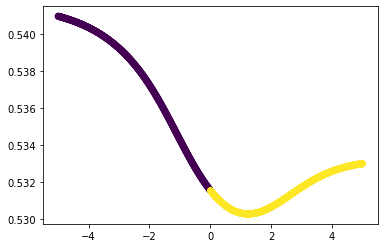

In [16]:
outputs = simple_network2(inputs)
plt.scatter(inputs,outputs,c=labels);

## Mini-Batch Notation

Note, this implementation runs an example through the network **one-by-one**! Instead, we can imagine feeding our entire dataset through **at once**! This formalism will pave the way for us later to feed in a mini-batch at a time.

Lets just reason our way through this one from **first-principles** (fancy way to say: **lets match our matrix sizes!**), seeing how we get our entire dataset through the first hidden layer. 

The first weight matrix is of size:

$$
\mathbf{W}_1: (\text{size of hidden layer} \times \text{dimension of input})
$$

which in this case is: $3 \times 1$. If our input was 2-D, it would be $3 \times 2$. So what we *dot* it with, needs to be of size: $\text{dimension of input} \times \text{??}$. 

**Its in that dimension that we can place our entire dataset!**

So, now we're going to be shuffling **activation matrices** around! In these activation matrices, each **column** is an activation for the last layer on a different training example! 

![](figures/activation-matrix.png)

So we expect the **first activation matrix** to be of size: $\text{dimension of input} \times \text{number of samples}$. This means this must also be the size of the initial input matrix for the first hidden layer. 


So, we can rewrite our layer propagation equation above for our entire dataset:

$$
\boxed{\mathbf{A}^L = \sigma(\mathbf{W}\mathbf{A}^{L-1} + \mathbf{b})}
$$

where we use **broadcasting rules** to let us add a vector $\mathbf{b}$ to a matrix. 

---

Lets make a special note about the **first hidden layer**, and how it processes our **input matrix**. 

Typically, we imagine our data matrix such that the first dimension is the `batch_size`:

![](figures/X.png)

This means **each row** of this matrix, corresponds to **one sample.**

So if our data matrix is of size $\text{batch_size} \times \text{dimension}$, in order for our first layer to calculate correctly, **we have to make the sizes work**! Meaning, our first layer should be: 

$$
\mathbf{A}^1 = \sigma(\mathbf{W}^1\mathbf{X}^T + \mathbf{b})
$$

where $X^T$ is:


![](figures/X-T.png)

<div class="info">
    
**Note:** Here we **define** the input matrix $X$ to be of size: $N \times d$. That is why we transpose it in the first layer. This is by no means universal, and different numerical libraries do it differently. You might come across libraries or papers to talks, where the input matrix is defined to be of size $d \times N$. If that is the case, the first layer does **not** need an $X^T$!

</div>

Now we can implement this simple network, using this notation! 

In [17]:
def simple_network2_batch(inputs):
    # assume inputs is of shape Nxd
    
    # initialize weight matrices - notice the dimensions
    W_1 = # EDIT HERE
    W_2 = # EDIT HERE
    W_3 = # EDIT HERE
    
    # and our biases
    b_1 = # EDIT HERE
    b_2 = # EDIT HERE
    b_3 = # EDIT HERE
    
    # NOTE - there is no for loop here! 
    
    # layer 1
    a_1 = # EDIT HERE

    # layer 2
    a_2 = # EDIT HERE

    # output layer
    output = # EDIT HERE
    
    return np.squeeze(np.asarray(outputs)).reshape(-1,1)

Now lets actually run our **entire dataset** through (since we aren't yet dealing with batches), to generate outputs:

In [18]:
inputs,labels = toy()
y_hat = outputs = simple_network2(inputs)

Just for fun, lets plot it! 

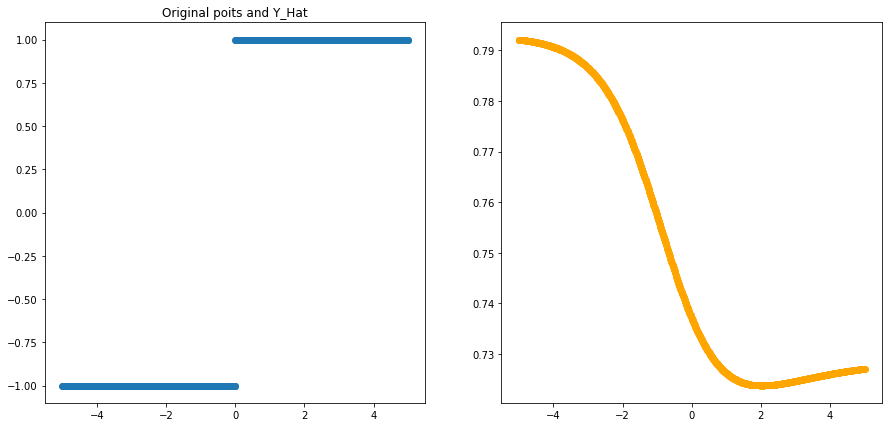

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.set_title('Original poits and labels')
ax1.scatter(inputs,labels);

ax1.set_title('Original poits and Y_Hat')
ax2.scatter(inputs,outputs,color='orange');

Note the huge difference in our y-axis! This is **without** and training so its bound to be bad! 

<div class="info">

**Pause-and-ponder**: Go back and re run the network above and re-plot the final representation. Notice how random it is! This is because we initialize with random weights, but never actually do any training! 
    
</div>

## Dealing with Biases

Another very common notational trick people do, as we saw in **linear regression**, was to **add "another dimension"** to "automatically" deal with our **bias**. 

Here,  that means adding **another "node" to each layer**. This node has **no input, only outputs**, and its **activation is always the value 1**.

![](figures/biases.png)

<div class="info">

**Question**: How does this act as a bias?
    
</div>

Well, lets look at what this means for a particular node. Lets once again highlight the orange node:

![](figures/bias-weights.png)

What **effect** does this have for this orange nodes update? Well, lets write out what it is:

![](figures/bias-weights-eqn.png)

So, $\color{orange}{w}_{\color{orange}{0},\color{blue}{3}}$ is **always** being multiplied by the value $1$. This is exactly the role of the bias! 

![](figures/bias-weights-eqn-simp.png)

As we can see, the addition of a constant node in a layer **gives an extra weight to each node in the next layer**. This weight, multiplied by 1, **acts as the bias for each node**. 

So all we have to do, is **add an extra <font color="red">column</font> to each weight matrix** in our network. (Note: often, this bias is omitted from the final layer).

Now, for a layer $L$, the **weight matrix** is of size: $k \times j+1$, where $k$ is the number of *actual*/*real* hidden nodes in layer $L$, and $j$ is the number of *actual/real* hidden nodes in layer $L-1$. 

**Note**: often this is drawn with the bias nodes on top of the others, not below. 
    
![](figures/bias-on-top.png)
    
So we would think of the 0-th weight acting as the bias, so we would add an extra column to the left/right of each weight matrix. Its ultimately the same thing
 

As a sanity check that this works, lets compare the output of the previous implementation with this new notation. To do so, we need to make sure they use the same initialization. Lets take it out of the function and "make it flat" so we can easily compare:

In [20]:
# W and b network
# initialize weight matrices - notice the dimensions
W_1 = # EDIT HERE
W_2 = # EDIT HERE
W_3 = # EDIT HERE

# and our biases
b_1 = # EDIT HERE
b_2 = # EDIT HERE
b_3 = # EDIT HERE

In [21]:
# W network - adding biases to the right:
W_1_b = np.hstack((W_1,b_1))
W_2_b = np.hstack((W_2,b_2))
W_3_b = np.hstack((W_3,b_3))

Lets run the "old network" notation:

In [22]:
# layer 1
a_1_old = # EDIT HERE

# layer 2
a_2_old = # EDIT HERE

# output layer
output_old = # EDIT HERE
output_old = np.squeeze(np.asarray(output_old)).reshape(-1,1)

And now the "new" network notation. Note: in order to run the inputs through, we need to add the "extra dimension of 1's", as we've done many times before!

In [23]:
inputs_new = np.c_[inputs,np.ones(inputs.shape[0])]

Now we can go ahead and "feed it in"

In [24]:
# layer 1
a_1_new = # EDIT HERE
# append the 1 to the end of the previous layers activations:
a_1_new = np.r_[a_1_new, np.ones((1,a_1_new.shape[1]))]

# layer 2
a_2_new = # EDIT HERE
# append the 1 to the end of the previous layers activations:
a_2_new = np.r_[a_2_new, np.ones((1,a_2_new.shape[1]))]

# output layer
output_new = # EDIT HERE
output_new = np.squeeze(np.asarray(output_new)).reshape(-1,1)

Lets verify they are both equal:

In [25]:
np.equal(output_new,output_old).all()

True

<div class="info">

**Note**: This might seem like **a strange hack** - We have to reshape each layers weight matrix, and each layers activation matrix to account for this extra "1" flying around everywhere. 

I will not try to convince you one way or the other which makes the most sense. I'm just explaining it here in case it is useful to you to think of the bias as "being wrapped up" in our weight matrix, as it was when we discussed linear regression. 
    
Moving forward, we will **not** be using this notation in the rest of the notebook.

</div>

## Activation Functions

Lets imagine revisiting the previous network structure under different activation functions:

### Linear

Lets start with a **linear activation** function:

In [26]:
def linear(z):
    return z

This is almost always called a linear activation, but is better thought of as the identity activation - that is, it just returns what it was given, unaltered.

What does this mean for the computation our network can perform? 

Once again, lets flatten our implementation to take a look:

In [27]:
inputs,labels = toy()

In [28]:
# initialize weight matrices - notice the dimensions
W_1 = # EDIT HERE
W_2 = # EDIT HERE
W_3 = # EDIT HERE

# and our biases
b_1 = # EDIT HERE
b_2 = # EDIT HERE
b_3 = # EDIT HERE

In [29]:
# layer 1
a_1 = # EDIT HERE

# layer 2
a_2 = # EDIT HERE

# output layer
outputs = # EDIT HERE
outputs = np.squeeze(np.asarray(outputs)).reshape(-1,1)

Lets plot it:

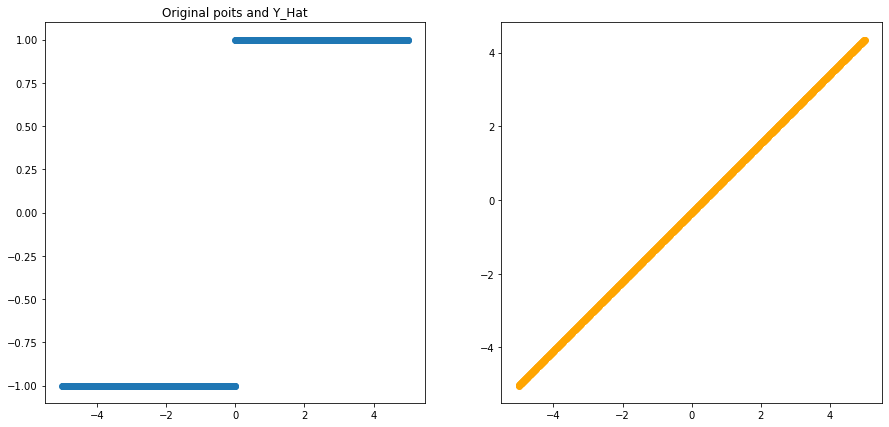

In [30]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
ax1.set_title('Original poits and labels')
ax1.scatter(inputs,labels);

ax1.set_title('Original poits and Y_Hat')
ax2.scatter(inputs,outputs,color='orange');

<div class="info">
    
🧐 **Pause-and-ponder**: Go back and re-run the above a few times. What does this mean?
    
</div>

Remember, what we are visualizing is the inputs and the corresponding output value - what our network has been able to map to.

You might be noticing that this is strangely linear! Indeed! With linear activation functions, all we are able to do is calculate some linear combination of our inputs! 

Lets dig in a bit more, and show what we are actually calculating at Layer $L$:

$$
A^L = W_3((W_2(W_1X^T + b_1) + b_2) + b_3
$$

Well, lets distribute this out:
$$
A^L = W_3W_2W_1X^T + W_3W_2b_1 + W_3b_2 + b_3
$$

Ok, wait a second... this is getting confusing - lets check to make sure the sizes work out! 

![](figures/linear-sizes.png)

<div class="info">

Lets go through this part together in class!

</div>

Ok! I can see that the sizes do in fact work out! 

<div class="info">

🧐**Pause-and-ponder:** After we make the necessary substitutions, what do we discover? 
    
</div>

### A Final Sigmoid

Given our understanding above, what would happen if we only add a sigmoid at the end? Something like:

![](figures/final-sig.png)

<div class="info">

🧐**Pause-and-ponder**: What do you think it represents? What is its **representational capacity**? 
    
</div>